In [1]:
import numpy as np
import pandas as pd
from cmaes import CMA
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
from pathlib import Path
from matplotlib import pyplot as plt

/Users/teppei/.local/share/virtualenvs/SETI-rgkZMqMW/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
expts = [
    "efficientnetb0_100epoch",
    "efficientnetv2s_100epoch",
    "efficientnetv2s_640",
    "efficientnetb0_640",
    "tf_efficientnet_b1_ns"
]

tta = [
    "",
    "tta_mean_",
    "tta_max_",
    "tta_min_",
    "tta_gmean_"
]

basedir = Path('.').resolve()

In [4]:
# read oof

train_df = pd.read_csv(basedir.parent / 'seti-breakthrough-listen' / 'train_labels.csv')

folds = list()
for _expt in expts:
    for _tta in tta:  
        _df = pd.read_csv(basedir / _expt / 'output' / f'{_tta}oof_prediction.csv')
        _df = _df.set_index('id')
        train_df[f'{_expt}_{_tta}'] = train_df.id.map(_df['target'])
        folds.append(_df['fold'].values)
    
assert all(np.all(folds[0] == _fold) for _fold in folds)

train_df['fold'] = folds[0]
# train_df.to_csv('./oof_prediction.csv')

In [5]:
# read test

test_df = pd.read_csv(basedir.parent / 'seti-breakthrough-listen' / 'sample_submission.csv')

for _expt in expts:
    for _tta in tta:
        _df = pd.read_csv(basedir / _expt / 'output' / f'{_tta}submission.csv')
        _df = _df.set_index('id')
        test_df[f'{_expt}_{_tta}'] = test_df.id.map(_df['target'])
# test_df.to_csv('./test_prediction.csv')

In [6]:
feature_cols = test_df.drop(columns=['id', 'target']).columns
# only tta_mean
feature_cols = [f for f in feature_cols if 'tta_mean' in f]
feature_cols

['efficientnetb0_100epoch_tta_mean_',
 'efficientnetv2s_100epoch_tta_mean_',
 'efficientnetv2s_640_tta_mean_',
 'efficientnetb0_640_tta_mean_',
 'tf_efficientnet_b1_ns_tta_mean_']

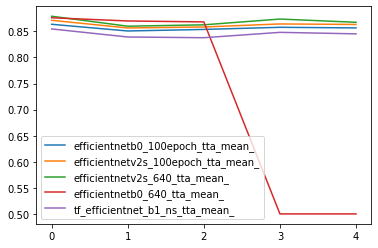

In [7]:
scores = dict()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

for f in feature_cols:
    y = list()
    for _fold in range(5):
        pred, target = train_df[_fold == train_df.fold][[f, 'target']].values.T
        y.append(roc_auc_score(target, pred))
    ax.plot(y, label=f)
    scores[f] = y
ax.legend()
ax.set_xticks(range(5))

# average
scores['average'] = list()
for _fold in range(5):
    _df = train_df[train_df.fold == _fold]
    target = _df['target'].values
    pred = _df[feature_cols].mean(axis=1).values
    pred = np.clip(pred, 0, 1)
    scores['average'].append(roc_auc_score(target, pred))

In [8]:
scores['efficientnetv2s_640_tta_mean_'], scores['average']

([0.8790613811728394,
  0.8599518518518519,
  0.8626253472222223,
  0.8736616126543209,
  0.8674788194444446],
 [0.8808450617283952,
  0.8714937500000001,
  0.8688291666666667,
  0.8736140432098765,
  0.8715133487654321])

## average 

In [9]:
pred = test_df[feature_cols].mean(axis=1).values
pred = np.clip(pred, 0, 1)

submission_df = test_df[['id', 'target']].copy()
submission_df['target'] = pred
submission_df.head()

,id,target
0,000bf832cae9ff1,0.076092
1,000c74cc71a1140,0.100852
2,000f5f9851161d3,0.077067
3,000f7499e95aba6,0.117945
4,00133ce6ec257f9,0.077540


In [10]:
submission_df.to_csv('submission.csv', index=False)

## CMA :whole data

In [15]:
def objective(x):
    df = train_df[train_df.fold <= 2]
    pred = np.dot(df[feature_cols].values, x)
    pred = np.clip(pred, 0, 1)
    target = df['target'].values
    return roc_auc_score(target, pred)


def softmax(x):
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x

In [16]:
def optimize(sigma, n_iters):
    weights = np.ones(len(feature_cols)) / len(feature_cols)

    optimizer = CMA(mean=weights, sigma=sigma)

    best = 0
    best_w = None
    for generation in range(n_iters):
        solutions = []
        for _ in range(optimizer.population_size):
            x = optimizer.ask()
            w = softmax(x)
            value = objective(w)
            solutions.append((x, -value))
            if best < value:
                best = value
                best_w = w
                print(f"#{generation} {np.round(value, 5)} {np.round(best_w, 3)}")
        optimizer.tell(solutions)
    
    return best, best_w

In [17]:
best_value, best_weights = optimize(sigma=1.3, n_iters=300)
best_value, best_weights

#0 0.86762 [0.197 0.527 0.018 0.062 0.195]
#0 0.87135 [0.063 0.021 0.07  0.419 0.427]
#0 0.8741 [0.119 0.424 0.284 0.144 0.03 ]
#0 0.87488 [0.086 0.043 0.262 0.517 0.092]
#1 0.87534 [0.209 0.076 0.305 0.358 0.052]
#2 0.87541 [0.169 0.178 0.143 0.495 0.014]
#2 0.87541 [0.296 0.129 0.244 0.327 0.004]
#3 0.87541 [0.269 0.037 0.261 0.428 0.006]
#12 0.87545 [0.162 0.102 0.329 0.374 0.034]
#12 0.87548 [0.201 0.177 0.316 0.294 0.012]
#14 0.87557 [0.231 0.132 0.244 0.38  0.012]
#16 0.87559 [0.172 0.169 0.204 0.447 0.008]
#17 0.8756 [0.216 0.178 0.226 0.377 0.003]
#17 0.87562 [0.187 0.118 0.295 0.397 0.003]
#17 0.87563 [0.214 0.155 0.245 0.384 0.003]
#21 0.87564 [0.192 0.176 0.235 0.395 0.002]
#22 0.87564 [0.194 0.178 0.251 0.376 0.001]
#22 0.87565 [0.209 0.13  0.273 0.387 0.   ]
#28 0.87566 [0.192 0.147 0.268 0.391 0.002]
#29 0.87566 [0.201 0.138 0.261 0.399 0.002]
#31 0.87566 [0.175 0.156 0.259 0.409 0.001]
#32 0.87566 [0.18  0.154 0.256 0.41  0.   ]
#46 0.87566 [0.181 0.158 0.263 0.399 0.   

(0.8756687242798354,
 array([1.88526113e-01, 1.51840305e-01, 2.62071420e-01, 3.97513052e-01,
        4.91103074e-05]))

In [20]:
np.round(best_weights, 3)

array([0.189, 0.152, 0.262, 0.398, 0.   ])

In [21]:
best_value, best_weights = optimize(sigma=0.5, n_iters=300)
best_value, best_weights

#0 0.87074 [0.258 0.373 0.1   0.091 0.177]
#0 0.87307 [0.234 0.107 0.163 0.237 0.259]
#0 0.87477 [0.119 0.192 0.27  0.28  0.138]
#0 0.87492 [0.075 0.158 0.192 0.446 0.13 ]
#1 0.87502 [0.057 0.118 0.226 0.514 0.086]
#2 0.87503 [0.04  0.16  0.257 0.444 0.1  ]
#2 0.87518 [0.06  0.15  0.318 0.401 0.071]
#3 0.87528 [0.078 0.147 0.307 0.406 0.061]
#4 0.87534 [0.074 0.222 0.234 0.419 0.051]
#7 0.87551 [0.118 0.206 0.256 0.393 0.027]
#8 0.87551 [0.171 0.158 0.223 0.414 0.034]
#10 0.87553 [0.143 0.203 0.232 0.397 0.025]
#12 0.87553 [0.155 0.145 0.24  0.432 0.029]
#12 0.87554 [0.222 0.128 0.25  0.378 0.022]
#12 0.87556 [0.171 0.181 0.218 0.41  0.02 ]
#13 0.87558 [0.146 0.14  0.294 0.408 0.012]
#15 0.87559 [0.151 0.139 0.252 0.449 0.009]
#16 0.87559 [0.181 0.189 0.212 0.408 0.009]
#17 0.8756 [0.166 0.188 0.211 0.428 0.008]
#18 0.87564 [0.17  0.138 0.251 0.438 0.003]
#19 0.87565 [0.209 0.144 0.245 0.401 0.001]
#20 0.87565 [0.177 0.157 0.235 0.43  0.002]
#23 0.87565 [0.175 0.159 0.266 0.397 0.003]


(0.8756687157064472,
 array([1.88748743e-01, 1.51680051e-01, 2.62162955e-01, 3.97400997e-01,
        7.25412476e-06]))

In [24]:
np.round(best_weights, 3)

array([0.189, 0.152, 0.262, 0.397, 0.   ])

In [26]:
weights = np.ones(len(feature_cols)) / len(feature_cols)
print(objective(weights))
weights = np.array([0, 0, 0, 1., 0.])
print(objective(weights))

0.8735993912894375
0.8711102151920439


In [28]:
# weighted combination
weights = np.array([0.189, 0.152, 0.262, 0.397, 0.   ])

pred = test_df[feature_cols].values
pred = np.dot(pred, weights)
pred = np.clip(pred, 0, 1)

submission_df = test_df[['id', 'target']].copy()
submission_df['target'] = pred
submission_df.to_csv('submission.csv', index=False)
submission_df.head()

,id,target
0,000bf832cae9ff1,0.072098
1,000c74cc71a1140,0.107707
2,000f5f9851161d3,0.078791
3,000f7499e95aba6,0.111505
4,00133ce6ec257f9,0.075263


In [52]:
sub_lb = pd.read_csv('./submission_pl0.767.csv')
sub_lb['target'] = np.clip(sub_lb['target'], 0, 1)
my_sub = pd.read_csv('./my_submission_pl0.770.csv')

submission_df = sub_lb.merge(my_sub, on='id')
submission_df['target'] = submission_df['target_x'] * 0.1 + submission_df['target_y'] * 0.9
submission_df['target'] = np.clip(submission_df['target'], 0, 1)
submission_df = submission_df[['id', 'target']]
submission_df.to_csv('submission.csv', index=False)
submission_df.head()

,id,target
0,000bf832cae9ff1,0.069418
1,000c74cc71a1140,0.104529
2,000f5f9851161d3,0.076608
3,000f7499e95aba6,0.120498
4,00133ce6ec257f9,0.073194
